<a href="https://colab.research.google.com/github/victor-radermecker/Capstone_JPMorgan/blob/conv-lstm/Notebooks-Colab/FishnetGeneration-Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q geopandas pillow

In [3]:
import ee
import sys
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [4]:
ee.Authenticate()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=3Pqvg7TaCx6jXQA-uN4IK5Mk7ofHqxlWUlj3s_aQ5_A&tc=HrDS4e5RHaIxaORI3jNKFeopO-NQ0s6M94bOQ5GVK7k&cc=Nu3mX8lFSz4on210mQCMoGcKuuuHDomJRUjm6G0WRJU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AZEOvhWm4dByMxa2nCAFZpmHHW23syUn5KnjSKiPKeCnel0L5cZDIZSUiNg

Successfully saved authorization token.


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive




# Loading packages



In [6]:
# import local modules
import sys
sys.path.append('/content/drive/MyDrive/src')

from Fishnet import Fishnet
from ImageExporter import ImageExporter
from ImageCorrector import ImageCorrector
from ImageProcessor import ImageProcessor

# update files automatically
%load_ext autoreload
%autoreload 2

# Authenticate to Earth Engine
ee.Initialize(project="jpmorgancapstone")

# Fishnet

First, we can generate the fishnet using the following code.

- We instantiate a `Fishnet` object
- We generate the fishnet
- We aggregated the fishnet into batches corresponding to the images to extract froom the GoogleEarth Engine

In [7]:
coords = {
    "Train": [-99.13, 28.91, -94.29, 31.1],
    "Valid": [-87.1731, 32.769, -83.883, 34.3718],
    "Test": [-80.1731, 35.269, -76.883, 36.8718]
}

In [8]:
dataset = "Valid"

In [9]:
# Generate a fishnet using a shapefile
fishnet_creator_example = Fishnet(
    tile_size_miles=0.25,
    coordinates=coords[dataset],#None,
    shapefile_path=None, #"/content/drive/MyDrive/Code/Gis/Texas_State_Boundary/State.shp",
    clip=False,
    overlay_method=None,
)

fishnet_creator_example.create_fishnet()

Using Coordinates to initialize fishnet.


100%|██████████| 443/443 [00:11<00:00, 40.15it/s]


Generating polygons...
Success. Fishnet created.

 Fishnet Object has the following attributes: 

+----------------+-----------------------+--------------------+
|     Metric     |        Degrees        |       Miles        |
+----------------+-----------------------+--------------------+
| Fishnet Width  |   3.2901000000000096  | 191.14745677543343 |
| Fishnet Height |   1.602800000000002   | 110.74274567022925 |
|  Tiles Width   | 0.0043030794894178825 |        0.25        |
|  Tiles Height  |  0.00361828558317967  |        0.25        |
+----------------+-----------------------+--------------------+


In [10]:
# creates batches of 4miles x 4miles
fishnet_creator_example.batch(16)

Batching fishnet... 

Success. Fishnet batched.

Fishnet Batch has the following attributes: 

+---------+--------+---------+
|  Metric | Tiles  | Batches |
+---------+--------+---------+
|   Rows  |  443   |    7    |
| Columns |  765   |    12   |
|  Cells  | 338895 |    84   |
+---------+--------+---------+
+--------------+---------------------+-------+
|    Metric    |       Degrees       | Miles |
+--------------+---------------------+-------+
| Batch Width  |  0.2753970873227445 |   16  |
| Batch Height | 0.23157027732349889 |   16  |
+--------------+---------------------+-------+


In [ ]:
a = fishnet_creator_example.fishnet

len(a[a['batch_id'] == 0])

256

In [ ]:
fishnet_creator_example.batch_width_degrees / fishnet_creator_example.tile_width_degrees

16.0

# Verification
Check if each tile is fully included within one batch

In [10]:
res = []
from tqdm import tqdm

# Check if each geometry of "fishnet.fishnet" is contained in the corresponding "fishnet.batches"
for i in tqdm(range(len(fishnet_creator_example.fishnet))):
    row = fishnet_creator_example.fishnet.iloc[i]
    batch_id = row['batch_id']

    if not fishnet_creator_example.batches.geometry[batch_id].contains(fishnet_creator_example.fishnet.geometry[i]):
        raise Exception("Batch {} does not contain fishnet tile {}".format(batch_id, i))


100%|██████████| 338895/338895 [00:46<00:00, 7356.35it/s]


This function below allows to check whether each fishnet tile is fully included within each batch.

In [ ]:
fishnet_creator_example.plot_batch_tiles(batch_id=0)

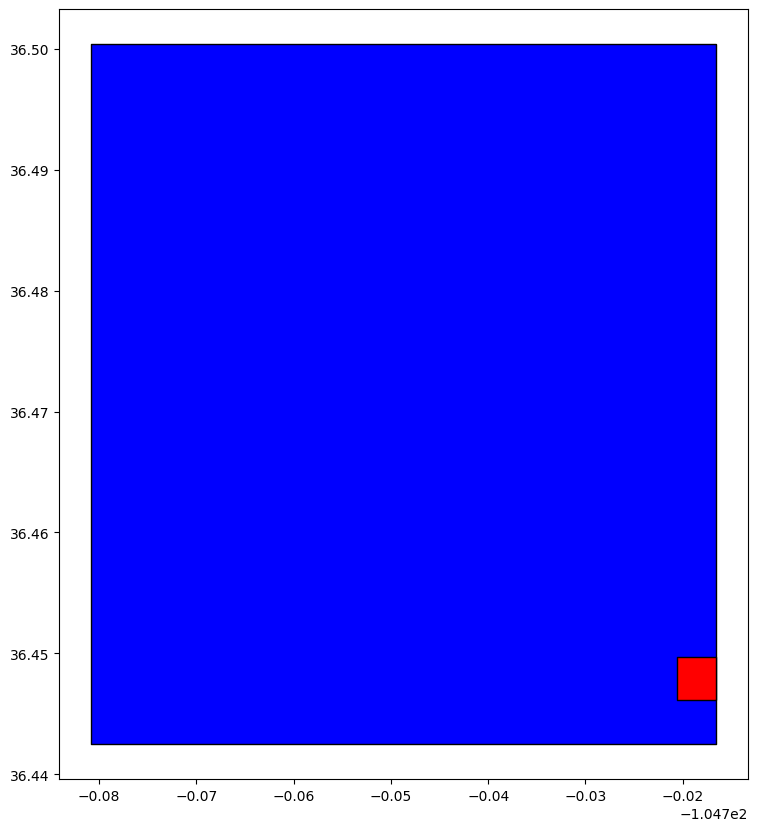

In [ ]:
fishnet_creator_example.plot_batch_tile(batch_id=29, tile_id=46245)

In [ ]:
fishnet_creator_example.batch_cols

205

In [ ]:
fishnet_creator_example.plot_fishnet()

Can't plot filtered fishnet for more than 10,000 tiles. Please try with a smaller fishnet.


# Save the fishnet object

In [ ]:
fishnet_creator_example.save('/content/drive/MyDrive/Code/Gis/Fishnet/fishnet_quarter_mile.pkl')

# Filter the fishnet

We can filter the `Fishnet` to one specific region to avoid working on the whole area, simply to increase computational speed.

In [ ]:
region = [-99.13, 28.91, -94.29, 31.1]

# Filter the fishnet by the larger bounding box
fishnet_creator_example.filter_fishnet_by_bbox(region)

In [ ]:
fishnet_creator_example.plot_filtered_fishnet()

Can't plot filtered fishnet for more than 10,000 tiles. Please try with a smaller fishnet.


# Process neighbors

In [9]:
fishnet_creator_example.compute_neighbors()

Computing neighbors...: 765it [00:04, 153.71it/s]


All neighbors computed successfully.


In [10]:
fishnet_creator_example.plot_neighbor(3569)

In [ ]:
# save the final version as well
fishnet_creator_example.save('/content/drive/MyDrive/Code/Gis/Fishnet/fishnet_quarter_mile_filtered&neighbors.pkl')

# Load the fishnet

In [ ]:
# load the object
fishnet_creator_example = Fishnet.load('/content/drive/MyDrive/Code/Gis/Fishnet/fishnet_quarter_mile_filtered&neighbors.pkl')

In [ ]:
fishnet_creator_example.filtered_fishnet.head()

,id,geometry,batch_id,neighbors
6060154,6060154,"POLYGON ((-95.79985 29.79208, -95.79985 29.795...",23743,"[6056884, 6056885, 6056886, 6060153, 6060155, ..."
6060155,6060155,"POLYGON ((-95.79583 29.79208, -95.79583 29.795...",23743,"[6056885, 6056886, 6056887, 6060154, 6060156, ..."
6060156,6060156,"POLYGON ((-95.79181 29.79208, -95.79181 29.795...",23743,"[6056886, 6056887, 6056888, 6060155, 6060157, ..."
6060157,6060157,"POLYGON ((-95.78778 29.79208, -95.78778 29.795...",23743,"[6056887, 6056888, 6056889, 6060156, 6060158, ..."
6060158,6060158,"POLYGON ((-95.78376 29.79208, -95.78376 29.795...",23743,"[6056888, 6056889, 6056890, 6060157, 6060159, ..."


# Export Images from the Google Earth Engine

In [ ]:
image_exporter = ImageExporter(fishnet_creator_example, filtered=False)

for period in ["year"]: #, "summer"]
    for year in [2016, 2017, 2018, 2019, 2020, 2021, 2022]:

        if period == "summer":
            image_exporter.set_date_range(year, year, '05', '10')
        else:
            image_exporter.set_date_range(year, year, '01', '12')

        image_exporter.set_folder(f'{period}_export_{year}')
        image_exporter.export_images()

100%|██████████| 84/84 [00:22<00:00,  3.66it/s]


# Correct Images

In [11]:
# list files in certain path
!ls /content/drive/MyDrive/Google\ Earth\ Exports/Valid/2016/Summer/


landcover_batchID_0.tif   landcover_batchID_35.tif  landcover_batchID_60.tif
landcover_batchID_10.tif  landcover_batchID_36.tif  landcover_batchID_61.tif
landcover_batchID_11.tif  landcover_batchID_37.tif  landcover_batchID_62.tif
landcover_batchID_12.tif  landcover_batchID_38.tif  landcover_batchID_63.tif
landcover_batchID_13.tif  landcover_batchID_39.tif  landcover_batchID_64.tif
landcover_batchID_14.tif  landcover_batchID_3.tif   landcover_batchID_65.tif
landcover_batchID_15.tif  landcover_batchID_40.tif  landcover_batchID_66.tif
landcover_batchID_16.tif  landcover_batchID_41.tif  landcover_batchID_67.tif
landcover_batchID_17.tif  landcover_batchID_42.tif  landcover_batchID_68.tif
landcover_batchID_18.tif  landcover_batchID_43.tif  landcover_batchID_69.tif
landcover_batchID_19.tif  landcover_batchID_44.tif  landcover_batchID_6.tif
landcover_batchID_1.tif   landcover_batchID_45.tif  landcover_batchID_70.tif
landcover_batchID_20.tif  landcover_batchID_46.tif  landcover_batchID_71.tif


In [14]:
corrector = ImageCorrector(f'/content/drive/MyDrive/Google Earth Exports/{dataset}/')

Loading images...:   0%|          | 0/7 [01:59<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
corrector.correct_images()

Imputing Summer missing pixels with Year data. Processing images...
Processing images for year 2022: 100%|██████████| 117/117 [00:11<00:00, 10.35it/s]


<font color = 'red'> Weird output but code seems fine. There's a random element in this, it's not always the same... </font>

In [ ]:
corrector.summary_final()

Loading images...: 100%|██████████| 7/7 [00:53<00:00,  7.71s/it]
+------+--------------+---------------------+--------------------+
| Year | Final Images | Final Black Pixel % | Final Snow Pixel % |
+------+--------------+---------------------+--------------------+
| 2016 |     117      |       0.0000%       |      0.0018%       |
| 2017 |     117      |       0.0000%       |      0.0024%       |
| 2018 |     117      |       0.0000%       |      0.0005%       |
| 2019 |     117      |       0.0000%       |      0.0009%       |
| 2020 |     117      |       0.0000%       |      0.0022%       |
| 2021 |     117      |       0.0000%       |      0.0021%       |
| 2022 |     117      |       0.0000%       |      0.0008%       |
+------+--------------+---------------------+--------------------+


# Process Images

In [ ]:
img_process = ImageProcessor(
    fishnet_creator_example,
    filtered=False,
)

In [ ]:
img_process.assign_fishnet_tiles_to_pixels(
    f"/content/drive/MyDrive/Google Earth Exports/{dataset}/{2016}/Final/", "landcover_batchID"
)

Processing Images:   0%|          | 0/117 [00:00<?, ?it/s]

In [ ]:
for year in tqdm([2016, 2017, 2018, 2019, 2020, 2021, 2022]):
    # Compute urbanization rate
    img_process.compute_mean_tile_entropy_urbanization(
        f"/content/drive/MyDrive/Google Earth Exports/{year}/Final/", "landcover_batchID", f"MeanPixel_{year}", f"Entropy_{year}"
    )

  0%|          | 0/7 [00:00<?, ?it/s]

Processing Images:   0%|          | 0/117 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:10<01:00, 10.15s/it]

Processing Images:   0%|          | 0/117 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:21<00:53, 10.78s/it]

Processing Images:   0%|          | 0/117 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:32<00:44, 11.03s/it]

Processing Images:   0%|          | 0/117 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:43<00:33, 11.12s/it]

Processing Images:   0%|          | 0/117 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:54<00:22, 11.02s/it]

Processing Images:   0%|          | 0/117 [00:00<?, ?it/s]

 86%|████████▌ | 6/7 [01:12<00:13, 13.41s/it]

Processing Images:   0%|          | 0/117 [00:00<?, ?it/s]

100%|██████████| 7/7 [01:35<00:00, 13.65s/it]


In [ ]:
# Save the new fishnet
fishnet_creator_example.save('/content/drive/MyDrive/Code/Gis/Fishnet/fishnet_quarter_mile_completed.pkl')

In [ ]:
fishnet_creator_example.filtered_fishnet.head()

,id,geometry,batch_id,neighbors,ImageCoordinates,Width,Height,MeanPixel_2016,Entropy_2016,MeanPixel_2017,...,MeanPixel_2018,Entropy_2018,MeanPixel_2019,Entropy_2019,MeanPixel_2020,Entropy_2020,MeanPixel_2021,Entropy_2021,MeanPixel_2022,Entropy_2022
6060154,6060154.0,"POLYGON ((-95.79985 29.79208, -95.79985 29.795...",23743.0,"[6056884, 6056885, 6056886, 6060153, 6060155, ...","(403, 524, 448, 564)",45.0,40.0,181.191667,0.868003,197.341667,...,222.275000,0.552850,219.583333,0.581321,225.958333,0.511536,233.041667,0.423354,237.008333,0.367993
6060155,6060155.0,"POLYGON ((-95.79583 29.79208, -95.79583 29.795...",23743.0,"[6056885, 6056886, 6056887, 6060154, 6060156, ...","(448, 524, 492, 564)",44.0,40.0,204.724432,0.716210,213.272727,...,229.355114,0.470794,228.485795,0.481478,230.948864,0.450721,237.613636,0.359102,241.815341,0.293594
6060156,6060156.0,"POLYGON ((-95.79181 29.79208, -95.79181 29.795...",23743.0,"[6056886, 6056887, 6056888, 6060155, 6060157, ...","(492, 524, 537, 564)",45.0,40.0,140.250000,0.992774,133.025000,...,136.708333,0.996234,147.333333,0.982474,148.750000,0.979869,168.583333,0.923751,168.583333,0.923751
6060157,6060157.0,"POLYGON ((-95.78778 29.79208, -95.78778 29.795...",23743.0,"[6056887, 6056888, 6056889, 6060156, 6060158, ...","(537, 524, 582, 564)",45.0,40.0,114.041667,0.991948,100.583333,...,114.466667,0.992449,205.700000,0.708393,223.833333,0.535715,214.200000,0.634310,217.458333,0.602845
6060158,6060158.0,"POLYGON ((-95.78376 29.79208, -95.78376 29.795...",23743.0,"[6056888, 6056889, 6056890, 6060157, 6060159, ...","(582, 524, 627, 564)",45.0,40.0,197.200000,0.772155,198.900000,...,195.358333,0.784729,210.941667,0.664020,212.075000,0.653878,196.066667,0.779943,206.550000,0.701471



# <font color = 'red'> Fix Image Processor Class </font>